In [1]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

In [2]:
from datasets import Dataset, DatasetDict
import os
import json
import torch
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_cap = -1
set_data = None
dataset_sets = {}
dict_sets = {}
# data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"
# data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-babelscape-sredfm-llama-11cls-rebalPairs0.5x-rwrtKeys-instrC-mxTrnCp3-skpTps-BblscpSrdfm-prepBART"
data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"

data_stem = data_folder.split('/')[-1]
base_model = 'facebook/bart-base'
model_path = f"/mnt/vdb1/murilo/models/fine-tuned/{base_model}/{data_stem}"

args_dict = {
    'memorization_task': False,
    'merge_train_dev': False
}


for set_ in ('train', 'test', 'dev'):

    data_path = os.path.join(data_folder, f'{set_}.json')

    with open(data_path, 'r') as f:
        data = json.load(f)
            
    # Remap keys and separate into train/test
    if args_dict['memorization_task']:
        if not set_data:
            set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data[data_cap:]]
    else:
        set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data]
        
    # Merge 'train' and 'dev' if the flag is set
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            dict_sets['train'] = dict_sets['train'] + set_data
        else:
           dict_sets[set_] = set_data
    else:
        dict_sets[set_] = set_data
        

    
for set_ in ('train', 'test', 'dev'):
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            continue
    set_data = dict_sets[set_]
    dataset_sets[set_] = Dataset.from_dict(
        {"text": [item["text"] for item in set_data],
         "summary": [item["summary"] for item in set_data],
         "title": [item["title"] for item in set_data]}
        )
    

# Create DatasetDict
dataset_dict = DatasetDict(dataset_sets)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 2304
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 841
    })
    dev: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 705
    })
})

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# Specify your directory path

all_folders = [f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))]

# If there's only one folder, set it as the checkpoint folder
if len(all_folders) == 1:
    checkpoint_folder = all_folders[0]
    full_checkpoint_path = os.path.join(model_path, checkpoint_folder)
    print(full_checkpoint_path)
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(full_checkpoint_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(full_checkpoint_path).to(device)
else:
    raise Exception("More than one checkpoint found. Be more specific!")

# Initialize an empty list to store raw_predicted_labels
raw_predicted_labels = []

# Loop through the test set
for entry in tqdm(dataset_dict['test']):
    text = entry['text']
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model.generate(inputs, max_length=300, do_sample=False)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_predicted_labels.append(summary)

# Confirm the shape
assert len(raw_predicted_labels) == len(dataset_dict['test'])


/mnt/vdb1/murilo/models/fine-tuned/facebook/bart-base/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/checkpoint-480

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/murilo/miniconda3/envs/llama-lora/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116_nocublaslt.so...
[2023-10-09 13:45:59,149] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)
100%|██████████| 841/841 [02:35<00:00,  5.42it/s]


In [4]:
raw_predicted_labels[:10]

['Speaker 5 is a parent of Speaker 1. Speaker 1 is a child of Speaker 5.',
 'Speaker 2 is a parent of Speaker 1. Speaker 1 is a child of Speaker 2.',
 'Speaker 2 is a parent of Speaker 3. Speaker 3 is a child of Speaker 2.',
 'Speaker 3 is a parent of Speaker 1. Speaker 1 is a child of Speaker 3.',
 'Speaker 1 is a sibling of Speaker 4. Speaker 4 is a parent of Speaker 1.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 1. Speaker 1 is a child of Speaker 4.',
 'Speaker 4 is a parent of Speaker 6. Speaker 6 is a child of Speaker 4.']

In [5]:
from src.processing.bart_processing import RelationConverter
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def convert_raw_labels_to_relations(raw_predicted_labels, input_path=''):
    converter = RelationConverter(input_path=input_path)
    predicted_labels = []
    error_count = 0  # Initialize error counter
    errors = []
    for raw_label in tqdm(raw_predicted_labels):
        label_relations = []
        if raw_label:
            for sent in sent_tokenize(raw_label): 
                try:
                    sub, rel, obj = converter._convert_sentence_to_relation(sent[:-1] if sent.endswith('.') else sent)
                except Exception as e:
                    sub, rel, obj = ("ERROR", "ERROR", "ERROR")
                    error = f'Exception `{e}` with sentence below:\n`{sent}`'
                    errors.append(error)
                    error_count += 1  # Increment error counter
                label_relations.append({'subject': sub, 'relation': rel, 'object': obj})

        predicted_labels.append(label_relations)

    # Confirm the shape
    assert len(raw_predicted_labels) == len(predicted_labels)
    
    # Print out the error ratio
    total_samples = len(raw_predicted_labels)
    error_ratio = (error_count / total_samples) * 100
    print(f'Errors: {error_count}/{total_samples} ({error_ratio:.2f}%)')

    return predicted_labels, errors  # Return tuple with predicted_labels and error_count

# Usage
predicted_labels, pred_errors = convert_raw_labels_to_relations(raw_predicted_labels)
print(predicted_labels[:3])


[nltk_data] Downloading package punkt to /home/murilo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initialized with input path: 
Output path set to         : -prepBART


100%|██████████| 841/841 [00:00<00:00, 20152.02it/s]

Errors: 7/841 (0.83%)
[[{'subject': 'Speaker 5', 'relation': 'parents', 'object': 'Speaker 1'}, {'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 5'}], [{'subject': 'Speaker 2', 'relation': 'parents', 'object': 'Speaker 1'}, {'subject': 'Speaker 1', 'relation': 'children', 'object': 'Speaker 2'}], [{'subject': 'Speaker 2', 'relation': 'parents', 'object': 'Speaker 3'}, {'subject': 'Speaker 3', 'relation': 'children', 'object': 'Speaker 2'}]]


In [6]:
true_labels, true_errors = convert_raw_labels_to_relations(dataset_dict['test']['summary'])

Initialized with input path: 
Output path set to         : -prepBART


  0%|          | 0/841 [00:00<?, ?it/s]

100%|██████████| 841/841 [00:00<00:00, 26344.01it/s]

Errors: 0/841 (0.00%)


In [7]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics
from src.config import get_config_from_stem
config = get_config_from_stem(data_stem)
evaluator = RelationExtractorEvaluator(config=config)
df = evaluator.assess_performance_on_lists(
    true_labels_list=true_labels, pred_labels_list=predicted_labels, return_details=True,
    # output_path=f'/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART/{base_model}'
    )
df

output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA
self.skip_types=True, forcing intruction_type to `C`...
output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-balPairs-rebalPairs-rwrtKeys-instrC-skpTps
Not output_path provided, nothing dump!
# INFERENCE REPORT
None



,id,prompt,dialogue,true_labels,raw_inference,predicted_labels,correct_labels,wrong_labels,missing_labels,f1s,precision,recall,error_message
0,1,,None,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 5"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Montauk"",\n ""relation"": ...",0.0,0.0,0.0,
1,2,,None,[],None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],0.0,0.0,0.0,
2,3,,None,[],None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],0.0,0.0,0.0,
3,4,,None,[],None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],0.0,0.0,0.0,
4,5,,None,[],None,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",[],0.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,837,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],[],1.0,1.0,1.0,
837,838,,None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",0.0,0.0,0.0,
838,839,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...","[\n {\n ""subject"": ""New York"",\n ""relation"":...",0.0,0.0,0.0,
839,840,,None,"[\n {\n ""subject"": ""Speaker 4"",\n ""relation""...",None,"[\n {\n ""subject"": ""Speaker 3"",\n ""relation""...",[],"[\n {\n ""subject"": ""New York"",\n ""relation"":...","[\n {\n ""subject"": ""New York"",\n ""relation"":...",0.0,0.0,0.0,


In [250]:
from src.processing.relation_extraction_evaluator import GranularMetricVisualizer
metric_visualizer = GranularMetricVisualizer(df=df, model_name=base_model, test_dataset_stem=data_stem)
output_metrics = metric_visualizer.dump_metrics()


output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA
outpath= /home/murilo/RelNetCare/data/reports/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps/facebook/bart-base/README.md
self.data_readme= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps/README.md


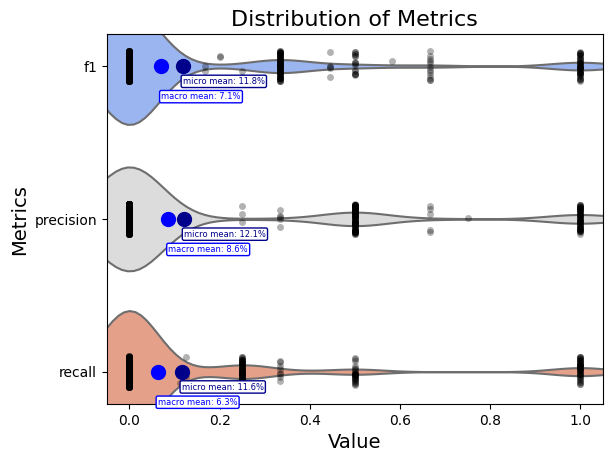

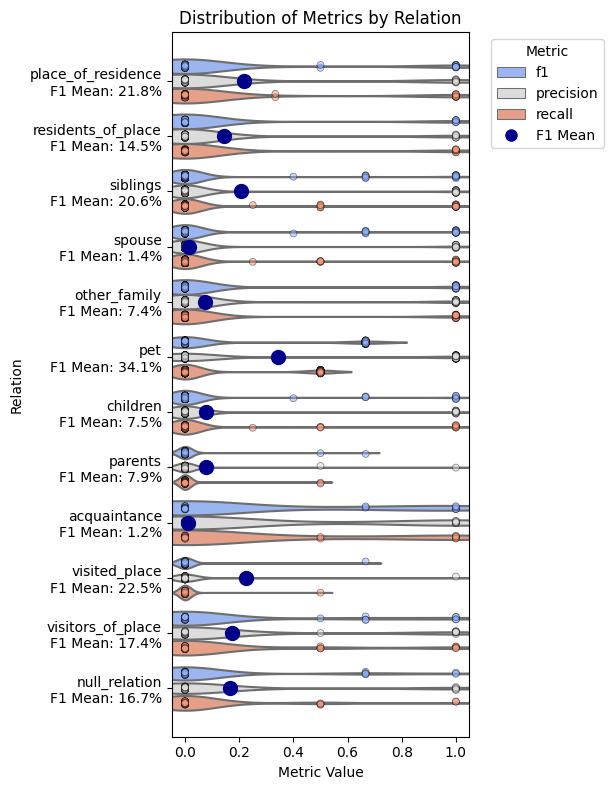

In [307]:
from src.processing.relation_extraction_evaluator import GranularMetricVisualizer
metric_visualizer = GranularMetricVisualizer(df=df, model_name=base_model, test_dataset_stem=data_stem)
metric_visualizer.visualize_class_metrics_distribution(df)
df_metrics_sample = metric_visualizer.visualize_class_metrics_distribution_per_class(df)
output_metrics = metric_visualizer.dump_metrics()

In [15]:
# # Release GPU
model.cpu()
del model
torch.cuda.empty_cache()
